# Neural Networks For Market Trading

In [42]:
import pandas as pd
df = pd.read_csv("dji_30.csv")

#Check if NA values are in data
# df=df[df['volume']!=0]
df.reset_index(drop=True, inplace=True)
df.isna().sum()
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
478,2023-11-28,353.489990,355.140015,353.089996,354.109985,354.109985,2759600
479,2023-11-29,354.970001,356.130005,354.369995,354.649994,354.649994,2736300
480,2023-11-30,356.709991,360.179993,356.450012,360.000000,360.000000,4094300
481,2023-12-01,360.019989,363.250000,359.859985,363.049988,363.049988,5850900
482,2023-12-04,361.149994,362.950012,361.019989,362.640015,362.640015,4211000


In [3]:
!pip3 install pandas

  Using cached pandas-2.1.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
  Using cached numpy-1.26.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
  Using cached pytz-2023.3.post1-py2.py3-none-any.whl (502 kB)


# Support and Resistance FUNCTIONS

In [43]:
def support(df1, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df1.Low[i]>df1.Low[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df1.Low[i]<df1.Low[i-1]):
            return 0
    return 1

def resistance(df1, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df1.High[i]<df1.High[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df1.High[i]>df1.High[i-1]):
            return 0
    return 1

In [51]:
length = len(df)
high = list(df['High'])
low = list(df['Low'])
close = list(df['Close'])
open = list(df['Open'])
bodydiff = [0] * length

highdiff = [0] * length
lowdiff = [0] * length
ratio1 = [0] * length
ratio2 = [0] * length

def isEngulfing(l):
    row=l
    bodydiff[row] = abs(open[row]-close[row])
    if bodydiff[row]<0.000001:
        bodydiff[row]=0.000001      

    bodydiffmin = 0.002
    if (bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
        open[row-1]<close[row-1] and
        open[row]>close[row] and 
        (open[row]-close[row-1])>=-0e-5 and close[row]<open[row-1]): #+0e-5 -5e-5
        return 1

    elif(bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
        open[row-1]>close[row-1] and
        open[row]<close[row] and 
        (open[row]-close[row-1])<=+0e-5 and close[row]>open[row-1]):#-0e-5 +5e-5
        return 2
    else:
        return 0
       
def isStar(l):
    bodydiffmin = 0.0020
    row=l
    highdiff[row] = high[row]-max(open[row],close[row])
    lowdiff[row] = min(open[row],close[row])-low[row]
    bodydiff[row] = abs(open[row]-close[row])
    if bodydiff[row]<0.000001:
        bodydiff[row]=0.000001
    ratio1[row] = highdiff[row]/bodydiff[row]
    ratio2[row] = lowdiff[row]/bodydiff[row]

    if (ratio1[row]>1 and lowdiff[row]<0.2*highdiff[row] and bodydiff[row]>bodydiffmin):# and open[row]>close[row]):
        return 1
    elif (ratio2[row]>1 and highdiff[row]<0.2*lowdiff[row] and bodydiff[row]>bodydiffmin):# and open[row]<close[row]):
        return 2
    else:
        return 0
    
def closeResistance(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df.High[l]-min(levels, key=lambda x:abs(x-df.High[l])))<=lim
    c2 = abs(max(df.Open[l],df.Close[l])-min(levels, key=lambda x:abs(x-df.High[l])))<=lim
    c3 = min(df.Open[l],df.Close[l])<min(levels, key=lambda x:abs(x-df.High[l]))
    c4 = df.Low[l]<min(levels, key=lambda x:abs(x-df.High[l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0
    
def closeSupport(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df.Low[l]-min(levels, key=lambda x:abs(x-df.Low[l])))<=lim
    c2 = abs(min(df.Open[l],df.Close[l])-min(levels, key=lambda x:abs(x-df.Low[l])))<=lim
    c3 = max(df.Open[l],df.Close[l])>min(levels, key=lambda x:abs(x-df.Low[l]))
    c4 = df.High[l]>min(levels, key=lambda x:abs(x-df.Low[l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0

In [56]:
n1=2
n2=2
backCandles=30
signal = [0] * length

for row in range(backCandles, len(df)-n2):
    ss = []
    rr = []
    for subrow in range(row-backCandles+n1, row+1):
        if support(df, subrow, n1, n2):
            ss.append(df.Low[subrow])
        if resistance(df, subrow, n1, n2):
            rr.append(df.High[subrow])
    #!!!! parameters
    if ((isEngulfing(row)==1 or isStar(row)==1) and closeResistance(row, rr, 150e-5) ):#and df.RSI[row]<30
        signal[row] = 1
    elif((isEngulfing(row)==2 or isStar(row)==2) and closeSupport(row, ss, 150e-5)):#and df.RSI[row]>70
        signal[row] = 2
    else:
        signal[row] = 0



In [57]:
df['signal']=signal

In [53]:
df[df['signal']==1].count()

Date         7
Open         7
High         7
Low          7
Close        7
Adj Close    7
Volume       7
signal       7
dtype: int64

In [59]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,signal
0,2022-01-03,364.339996,365.850006,362.299988,365.679993,352.397278,5624100,0
1,2022-01-04,367.339996,369.209991,367.209991,367.869995,354.507782,5462200,0
2,2022-01-05,367.709991,369.500000,363.980011,364.089996,350.865082,7638000,0
3,2022-01-06,364.109985,364.649994,361.959991,362.390015,349.226746,7019800,0
4,2022-01-07,361.890015,363.869995,361.130005,362.309998,349.149658,5806300,0
...,...,...,...,...,...,...,...,...
478,2023-11-28,353.489990,355.140015,353.089996,354.109985,354.109985,2759600,0
479,2023-11-29,354.970001,356.130005,354.369995,354.649994,354.649994,2736300,0
480,2023-11-30,356.709991,360.179993,356.450012,360.000000,360.000000,4094300,0
481,2023-12-01,360.019989,363.250000,359.859985,363.049988,363.049988,5850900,0


In [60]:
df.columns = ['Date', 'Open', 'High', 'Low', 'Close','Adj Cloe', 'Volume', 'signal']
df=df.iloc[100:200]
df

,Date,Open,High,Low,Close,Adj Cloe,Volume,signal
100,2022-05-26,322.950012,327.769989,322.899994,326.450012,316.877472,3270200,0
101,2022-05-27,327.049988,332.130005,326.820007,332.070007,322.332642,2773100,0
102,2022-05-31,330.170013,332.549988,327.660004,330.200012,320.517548,4354000,0
103,2022-06-01,332.410004,332.950012,326.100006,328.359985,318.731476,3721400,1
104,2022-06-02,328.549988,332.779999,325.359985,332.769989,323.012207,3718800,0
...,...,...,...,...,...,...,...,...
195,2022-10-12,292.459991,294.570007,291.369995,292.160004,285.673981,4378700,0
196,2022-10-13,287.140015,301.730011,286.619995,300.559998,293.887512,7389600,0
197,2022-10-14,302.540009,304.359985,296.190002,296.820007,290.230530,5519400,0
198,2022-10-17,300.890015,303.209991,299.980011,302.059998,295.354187,3555700,0


In [61]:
def SIGNAL():
    return df.signal

In [39]:
#A new strategy needs to extend Strategy class and override its two abstract methods: init() and next().
#Method init() is invoked before the strategy is run. Within it, one ideally precomputes in efficient, 
#vectorized manner whatever indicators and signals the strategy depends on.
#Method next() is then iteratively called by the Backtest instance, once for each data point (data frame row), 
#simulating the incremental availability of each new full candlestick bar.

#Note, backtesting.py cannot make decisions / trades within candlesticks — any new orders are executed on the
#next candle's open (or the current candle's close if trade_on_close=True). 
#If you find yourself wishing to trade within candlesticks (e.g. daytrading), you instead need to begin 
#with more fine-grained (e.g. hourly) data.

In [67]:
from backtesting import Strategy

class MyCandlesStrat(Strategy):  
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next() 
        if self.signal1==2:
            sl1 = self.data.Close[-1] - 600e-4
            tp1 = self.data.Close[-1] + 450e-4
            self.buy(sl=sl1, tp=tp1)
        elif self.signal1==1:
            sl1 = self.data.Close[-1] + 600e-4
            tp1 = self.data.Close[-1] - 450e-4
            self.sell(sl=sl1, tp=tp1)

In [68]:
from backtesting import Backtest

bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.00)
stat = bt.run()
stat



/tmp/ipykernel_12758/1132592598.py:3: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.00)


Start                                   100.0
End                                     199.0
Duration                                 99.0
Exposure Time [%]                         2.0
Equity Final [$]                  9924.050492
Equity Peak [$]                       10000.0
Return [%]                          -0.759495
Buy & Hold Return [%]               -6.426715
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.759495
Avg. Drawdown [%]                   -0.759495
Max. Drawdown Duration                   36.0
Avg. Drawdown Duration                   36.0
# Trades                                  2.0
Win Rate [%]                              0.0
Best Trade [%]                           -0.0
Worst Trade [%]                      -0.76433
Avg. Trade [%]                    

In [64]:
!pip3 install backtesting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 KB 1.4 MB/s eta 0:00:00 MB/s eta 0:00:01:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 7.4 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 KB 6.3 MB/s eta 0:00:00
  Using cached contourpy-1.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (310 kB)
  Using cached Pillow-10.1.0-cp310-cp310-manylinux_2_28_x86_64.whl (3.6 MB)
Using legacy 'setup.py install' for backtesting, since package 'wheel' is not installed.
  Running setup.py install for backtesting ... done


In [70]:
bt.plot()

/home/ha/Downloads/programs/jupyter/env/lib/python3.10/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/home/ha/Downloads/programs/jupyter/env/lib/python3.10/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p1677', ...)

In [71]:
#Target flexible way
pipdiff = 250*1e-4 #for TP
SLTPRatio = 1 #pipdiff/Ratio gives SL
def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None] * length
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)
        #if ( (valueOpenLow >= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 2 # bth limits exceeded
        #elif ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 3 #-1 downtrend
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
        #    trendcat[line] = 1 # uptrend
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 0 # no trend
        #elif ( (valueOpenLow >= (pipdiff/SLTPRatio)) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 5 # light trend down
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 4 # light trend up
            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

/tmp/ipykernel_12758/999573329.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Target'] = mytarget(30, df)


<Axes: >

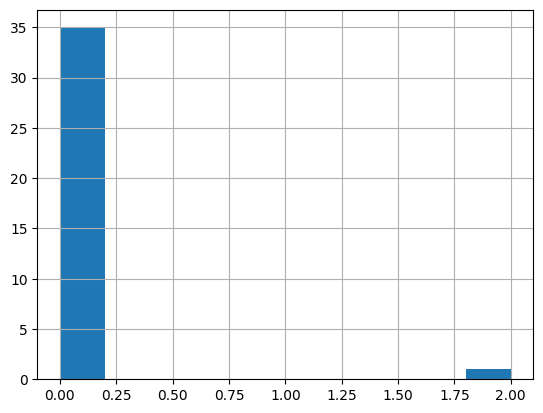

In [81]:
#!!! pitfall one category high frequency
df['Target'] = mytarget(30, df)
#df.tail(20)
#df['Target'] = df['Target'].astype(int)
df['Target'].hist()
# plt.show()  # This line is important to display the plot

In [77]:
!pip3 install matplotlib


  Using cached matplotlib-3.8.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
  Using cached kiwisolver-1.4.5-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 7.1 MB/s eta 0:00:00m eta 0:00:010:01:01


In [78]:
%matplotlib inline


In [83]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 KB 1.1 MB/s eta 0:00:001m564.5 kB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for pandas_ta, since package 'wheel' is not installed.
  Running setup.py install for pandas_ta ... done


In [96]:
import pandas_ta as pa
df["RSI"] = pa.rsi(df.Close, length=16)
df.tail(20)

/tmp/ipykernel_12758/161572885.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["RSI"] = pa.rsi(df.Close, length=16)


,Date,Open,High,Low,Close,Adj Cloe,Volume,signal,Target,RSI
0,2022-06-21,303.079987,306.470001,302.619995,305.290009,297.023315,3246500,0,0.0,NaN
1,2022-06-22,301.529999,307.679993,301.329987,304.609985,296.361664,6361200,0,0.0,NaN
2,2022-06-23,305.670013,307.059998,302.779999,306.739990,298.433990,3582600,0,0.0,NaN
3,2022-06-24,309.200012,315.119995,309.119995,315.019989,306.489777,3314800,0,0.0,NaN
4,2022-06-27,315.399994,315.890015,313.380005,314.359985,305.847687,1896500,0,0.0,NaN
5,2022-06-28,316.000000,318.750000,309.230011,309.339996,300.963654,3025900,0,0.0,NaN
6,2022-06-29,310.399994,311.480011,308.829987,310.049988,301.654388,2462800,0,0.0,NaN
7,2022-06-30,306.750000,309.820007,304.250000,307.820007,299.484833,4117800,0,0.0,NaN
8,2022-07-01,307.399994,311.309998,304.769989,310.850006,302.432678,3315000,0,0.0,NaN
9,2022-07-05,306.600006,309.760010,303.579987,309.709991,301.323608,3767700,0,0.0,NaN


In [97]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
print(df.describe())

             Open        High         Low       Close    Adj Cloe  \
count    4.000000    4.000000    4.000000    4.000000    4.000000   
mean   310.575005  313.597496  308.252502  311.954994  303.603523   
std      5.651306    5.056436    4.775525    4.862853    4.780777   
min    302.660004  306.859985  301.470001  306.399994  298.103241   
25%    308.772499  311.299995  307.229996  309.587494  301.299141   
50%    311.940002  314.565002  309.440002  311.654999  303.342667   
75%    313.742508  316.862503  310.462509  314.022499  305.647049   
max    315.760010  318.399994  312.660004  318.109985  309.625519   

             Volume  signal  Target        RSI  
count  4.000000e+00     4.0     4.0   4.000000  
mean   2.817600e+06     0.0     0.0  55.303273  
std    3.205645e+05     0.0     0.0   8.106993  
min    2.344900e+06     0.0     0.0  45.047888  
25%    2.756050e+06     0.0     0.0  51.556938  
50%    2.949000e+06     0.0     0.0  55.911197  
75%    3.010550e+06     0.0     0.0

/tmp/ipykernel_12758/1264523421.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [99]:
attributes = ['RSI', 'signal', 'Target']
df_model= df[attributes].copy()

df_model['signal'] = pd.Categorical(df_model['signal'])
dfDummies = pd.get_dummies(df_model['signal'], prefix = 'signalcategory')
df_model= df_model.drop(['signal'], axis=1)
df_model = pd.concat([df_model, dfDummies], axis=1)
df_model

,RSI,Target,signalcategory_0
0,45.047888,0.0,True
1,58.095773,0.0,True
2,53.726621,0.0,True
3,64.342809,0.0,True


In [101]:
!pip3 install scikit-learn

In [102]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss

attributes = ['RSI', 'signalcategory_0']
X = df_model[attributes]
y = df_model['Target']

train_pct_index = int(0.7 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

ImportError: sklearn needs to be installed in order to use this module

In [88]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 3.9 MB/s eta 0:00:00m eta 0:00:010:00:01
  Using cached scipy-1.11.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.4 MB)


In [103]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix_train = confusion_matrix(y_train, pred_train)
matrix_test = confusion_matrix(y_test, pred_test)

print(matrix_train)
print(matrix_test)

report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print(report_train)
print(report_test)
#choices = [2, 0, -1, +1]
##choices = [2, 0, 3, +1]
print(model.get_booster().feature_names)

NameError: name 'pred_train' is not defined

In [104]:
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
#pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
#plot feature importance
plot_importance(model)
pyplot.show()
print(model.get_booster().feature_names)

NameError: name 'model' is not defined

In [105]:
from sklearn.neural_network import MLPClassifier

attributes = ['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']
X = df_model[attributes]
y = df_model['Target']

train_pct_index = int(0.6 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

NN = MLPClassifier(hidden_layer_sizes=(50, 50, 60, 30, 9), random_state=100, verbose=0, max_iter=1000, activation='relu')
NN.fit(X_train, y_train)
pred_train = NN.predict(X_train)
pred_test = NN.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print("="*20)

print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test)) 

KeyError: "['signalcategory_1', 'signalcategory_2'] not in index"

In [106]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix_train = confusion_matrix(y_train, pred_train)
matrix_test = confusion_matrix(y_test, pred_test)

print(matrix_train)
print(matrix_test)

report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print(report_train)
print(report_test)

NameError: name 'pred_train' is not defined